In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import warnings
import torch
import numpy as np
import chnet.cahn_hill as ch
import matplotlib.pyplot as plt
from ipywidgets import interact
from toolz.curried import pipe, curry
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [50]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=3)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

In [6]:
@curry
def gen_data(nsamples=500, sim_steps=500, init_step=100, dim_x=101, dim_y=101, dx=0.25, dt=0.01, gamma=1.0, device = torch.device("cpu")):
    init_data1 = init_unif(nsamples//2, dim_x, dim_y, seed=354875)
    init_data2 = init_norm(nsamples//2, dim_x, dim_y, seed=982632)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=init_step, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    return x_data, y_data

In [17]:
# MKS model parameters
n_states = 7 # no. of terms in the legendre series
domain = (-1.1, 1.1) # range of local state
basis = LegendreBasis(n_states, domain) # descretizer tool

In [19]:
x_data, y_data = gen_data(nsamples=300)
x_val, y_val = gen_data(nsamples=50)

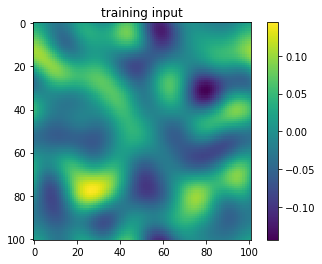

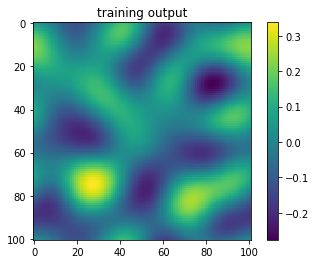

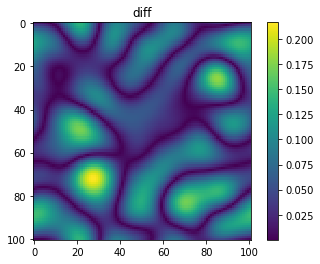

In [20]:
draw_im(x_data[0], "training input")
draw_im(y_data[0], "training output")

draw_im(np.fabs(x_data[0]-y_data[0]), "diff")

training error: 0.002
prediction error: 0.002
baseline error: 0.060


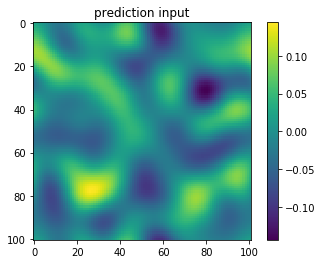

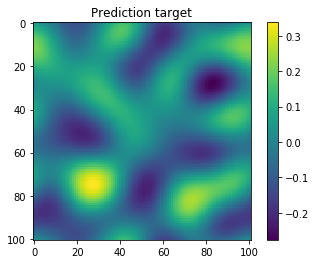

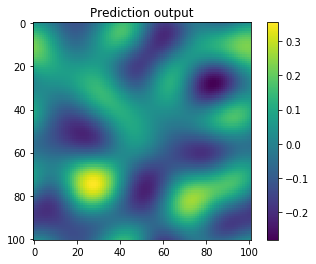

CPU times: user 27.2 s, sys: 2.66 s, total: 29.9 s
Wall time: 3.46 s


In [23]:
%%time
model = MKSLocalizationModel(basis)

model.fit(x_data, y_data)

y_train_pred = model.predict(x_data)
y_pred = model.predict(x_val)

print("training error: {:1.3f}".format(rmserror(y_train_pred, y_data)))
print("prediction error: {:1.3f}".format(rmserror(y_pred, y_val)))
print("baseline error: {:1.3f}".format(rmserror(y_val, x_val)))

draw_im(x_val[0], "prediction input")
draw_im(y_val[0], "Prediction target")
draw_im(y_pred[0], "Prediction output")

In [24]:
coeff = model.coef_
@interact
def draw(i = (0,n_states-1)):
#     plt.imshow(cropper(coeff[:,:,i]))
    plt.imshow(coeff[:,:,i])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=3, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

## Using MKS coefficients to predict forward time steps

In [25]:
%%time
steps = 10
y_pred = x_val.copy()
print(0, y_pred.shape, rmserror(y_pred, y_val))
for step in range(steps):
    try:
        y_pred = model.predict(y_pred)
        print(step+1, y_pred.shape, rmserror(y_pred, y_val))
    except Exception as err:
        print(step, err)
        break

0 (50, 101, 101) 0.06018037573316632
1 (50, 101, 101) 0.0019271737407894182
2 (50, 101, 101) 0.15543961772759235
2 X must be within the specified domain
CPU times: user 6.16 s, sys: 496 ms, total: 6.65 s
Wall time: 448 ms


### Determination of optimal number of legendre series terms

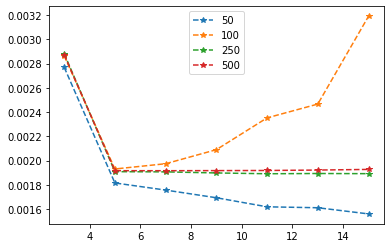

CPU times: user 36min 59s, sys: 4min 32s, total: 41min 32s
Wall time: 3min 8s


In [15]:
%%time

for nsample in [50, 100, 250, 500]:
    errs = []
    x_data, y_data = gen_data(nsamples=nsample)
    for ns in [3, 5, 7, 9, 11, 13, 15]:
        
        basis = LegendreBasis(ns, domain) # descretizer tool
        model = MKSLocalizationModel(basis)

        model.fit(x_data, y_data)

        y_train_pred = model.predict(x_data)
        y_pred = model.predict(x_val)

#         print("n_state : {}".format(ns))
#         print("trn err: {:1.6f}".format(rmserror(y_train_pred, y_data)))
#         print("prd err: {:1.6f}".format(rmserror(y_pred, y_val)))

        errs.append(rmserror(y_pred, y_val))

    plt.plot([3, 5, 7, 9, 11, 13, 15], errs, "--*")
plt.legend([50, 100, 250, 500])
plt.show()

## Save coeffs for different gammas

In [36]:
gamma_list = np.arange(start=0.5, stop=1.6, step=0.1 )

coeffs = []
errs = []

for g in gamma_list:

    x_data, y_data = gen_data(nsamples=300, gamma=g)
    x_val, y_val = gen_data(nsamples=50, gamma=g)

    basis = LegendreBasis(7, domain) # descretizer tool
    model = MKSLocalizationModel(basis)

    model.fit(x_data, y_data)
    y_pred = model.predict(x_val)

    errs.append(rmserror(y_pred, y_val))
    coeffs.append(model.coef_)

In [43]:
data = np.array([coeff.flatten() for coeff in coeffs])

In [47]:
pca = PCA(n_components=10)
scores = pca.fit_transform(data)

In [48]:
for comp in range(10):
    print(np.corrcoef(scores[:,comp], gamma_list)[0,1])

-0.5280747687801911
-0.45053073375260927
-0.39139151443616466
-0.42699218491703883
-0.22919048104073336
0.15883374776593737
-0.09482950252148721
-0.07953716338551137
-0.29557226008049764
-0.047024048136946744


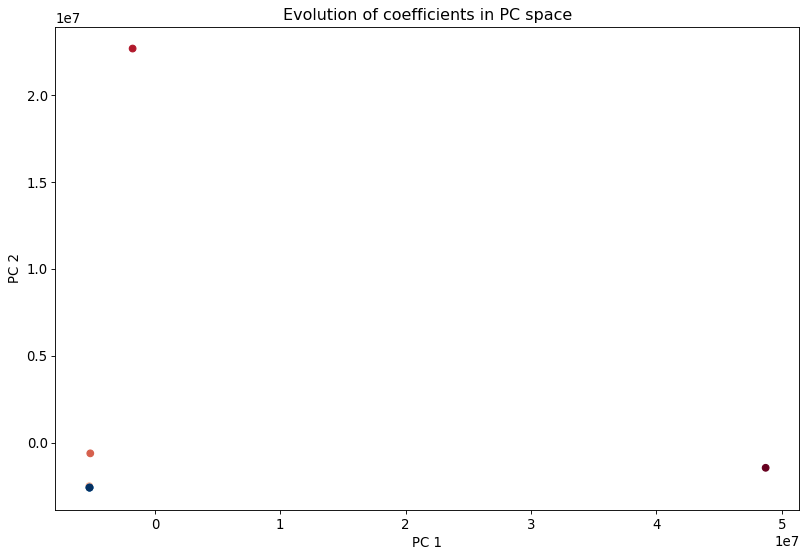

In [53]:
plt.scatter(scores[:,0], scores[:,1], c=np.arange(1,12), cmap='RdBu')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Evolution of coefficients in PC space")
plt.show()